In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output
import GPy
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
import numpy as np
from lab.tensorflow import B
from stheno import EQ, GP
from varz.tensorflow import Vars, minimise_l_bfgs_b
import sys

from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings('ignore')

# Main import 
from model import NSGPRegression

In [26]:
B.rand(100000).max()+1

1.9999964511904706

### Helper function

In [27]:
def fit_predict_plot(X, y):
    ## Stationary fit
    m = GPy.models.GPRegression(X, y, GPy.kern.RBF(X.shape[1]))
    m.optimize_restarts(5, verbose=False)
    
    pred_y, var_y = m.predict(X)
    pred_y = pred_y.ravel()
    std2_y = np.sqrt(var_y.ravel())*2

    fig, ax = plt.subplots(1,2,figsize=(12,3))
    ax[0].set_title('Stationary GP')
    ax[0].scatter(X, y, label='data')
    ax[0].plot(X, pred_y, label='pred_mean')
    ax[0].fill_between(X[:,0], pred_y.ravel()-std2_y, pred_y.ravel()+std2_y, alpha=0.3, label='95% conf')
    ax[0].set_xlabel('X'); ax[0].set_ylabel('y')
    ax[0].legend()
    
    ax[1].plot(X.ravel(), [m.kern.lengthscale]*len(y))
    ax[1].set_xlabel('X'); ax[1].set_ylabel('Lenghtscale');
    
    n_list = list(range(1, 11))
#     n_list = [5]
    n_restarts = 5
    obj_list = []
    best_models = []
    for n in n_list:
        best_loss = np.inf
        best_model = None
        for seed in range(n_restarts):
            clear_output(wait=True)
            print('n',n,'seed',seed)
            model = NSGPRegression(X, y, num_inducing_points=n, seed=seed)
            model.optimize()
            if model.GlobalGP(model.vs)<best_loss:
                best_loss = model.GlobalGP(model.vs)
                best_model = model
        
        obj_list.append(best_loss)
        best_models.append(best_model)
    
    X_new = np.linspace(X.min(), X.max(), 201).reshape(-1,1)
    for bi, best_model in zip(n_list, best_models):
        pred_y, var_y = best_model.predict(X_new)
        pred_y = pred_y.numpy()
        std2_y = np.sqrt(var_y.numpy().diagonal())*2
        
        fig, ax = plt.subplots(1,2,figsize=(12,3))
        ax[0].set_title('num_inducing_points = '+str(bi))
        ax[0].scatter(X, y, label='data')
        ax[0].plot(X_new, pred_y, label='pred_mean')
        ax[0].fill_between(X_new[:,0], pred_y.ravel()-std2_y, pred_y.ravel()+std2_y, alpha=0.3, label='95% conf')
        ax[0].set_xlabel('X'); ax[0].set_ylabel('y')
        ax[0].legend()

        ax[1].plot(X.ravel(), [m.kern.lengthscale]*len(y), label='Stat. LS')
        ax[1].plot(X_new.ravel(), np.array(best_model.LocalGP(best_model.vs, X_new)).ravel())
        ax[1].scatter(best_model.X_bar, best_model.vs['local_ls0']);
        ax[1].set_xlabel('X'); ax[1].set_ylabel('Lenghtscale');
        ax[1].legend()
    df = pd.DataFrame(np.vstack([n_list, obj_list]).T, columns=['n_inducing_points', 'Loss (nlml)'])
    plt.figure()
    plt.plot(df.n_inducing_points, df['Loss (nlml)'])
    plt.xlabel('num_inducing_points')
    plt.ylabel('Loss')
    plt.title('Num_inducing_points vs Loss')

### Data 1(Sin mix)

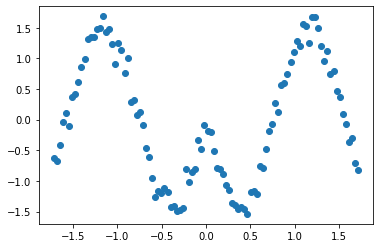

In [4]:
np.random.seed(0)
X = np.linspace(-1,1,100).reshape(-1,1)
# y = np.sin(10*X) + np.random.normal(0,0.1,100).reshape(-1,1)
y = np.sin(-np.abs(7*X)) + np.random.normal(0,0.1,100).reshape(-1,1)

X_scaled = StandardScaler().fit_transform(X)
y_scaled = StandardScaler().fit_transform(y)

plt.scatter(X_scaled, y_scaled);

n 10 seed 4


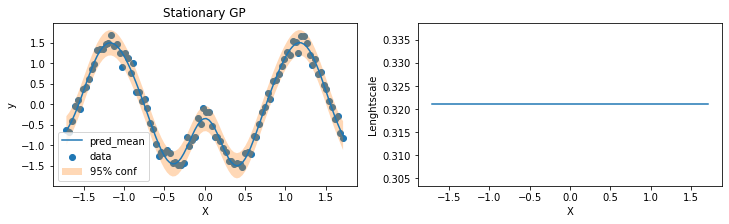

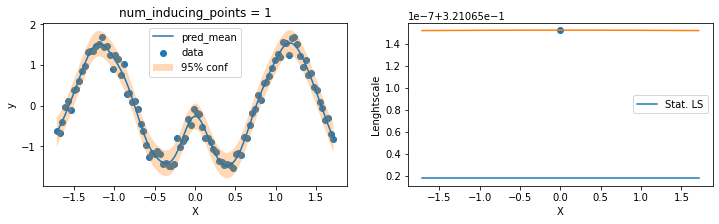

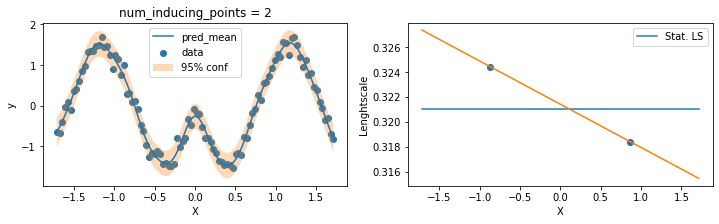

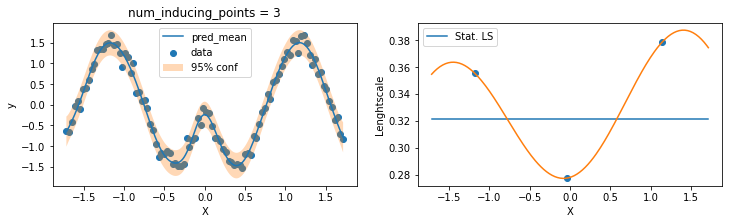

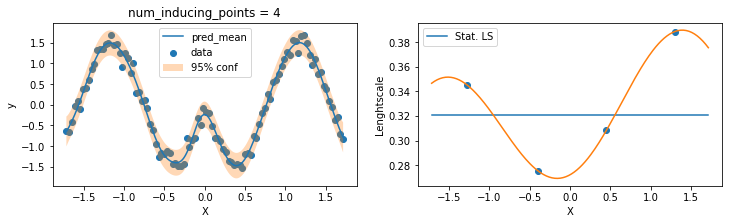

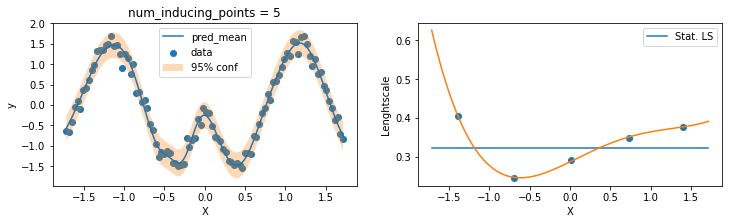

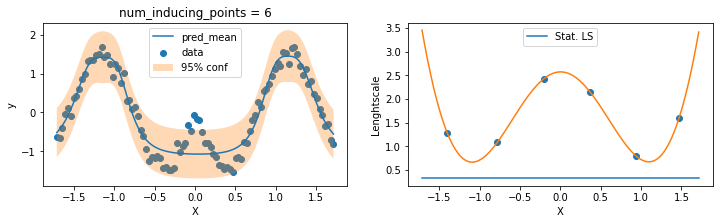

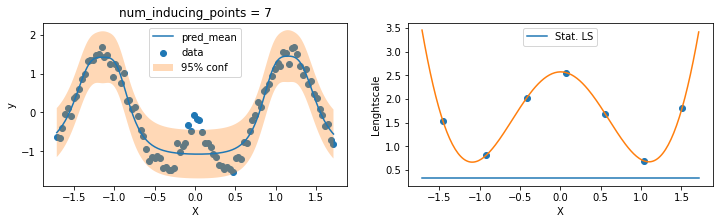

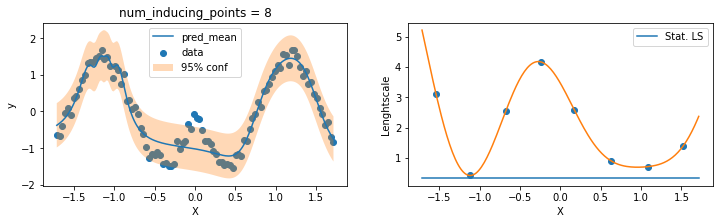

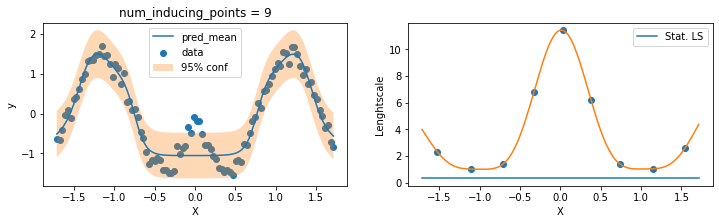

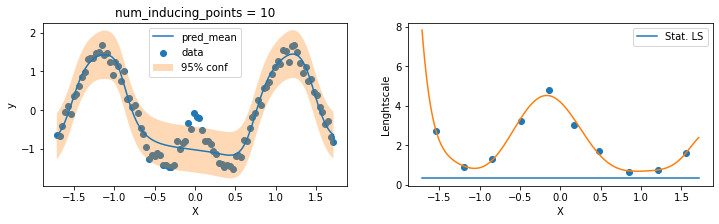

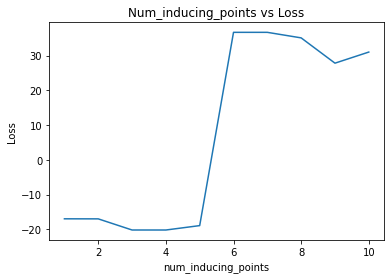

In [5]:
model = fit_predict_plot(X_scaled, y_scaled)

### Data2 (Olymplic marathon)

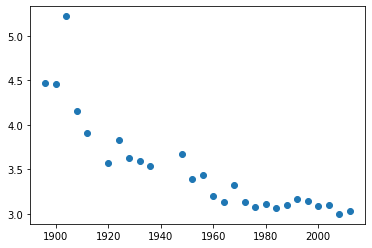

In [6]:
import pods

data = pods.datasets.olympic_marathon_men()
X = data['X']
y = data['Y']

plt.scatter(X, y);

n 10 seed 4


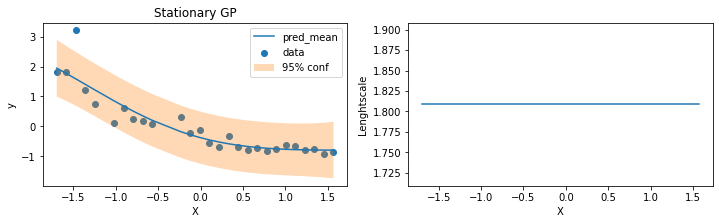

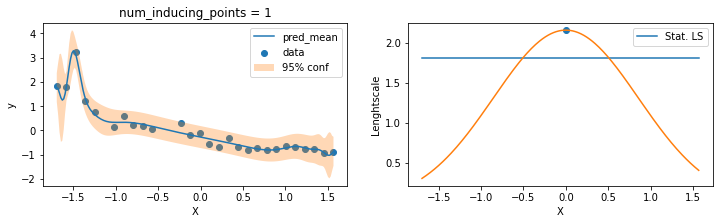

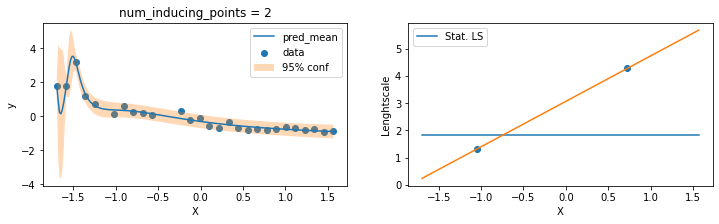

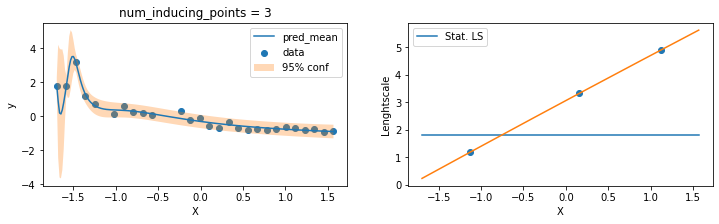

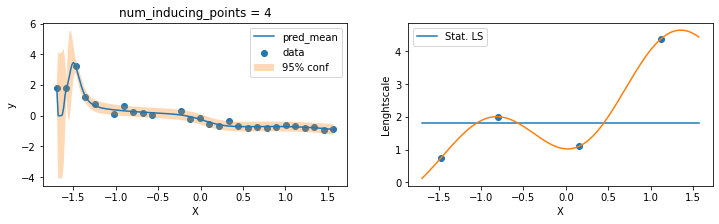

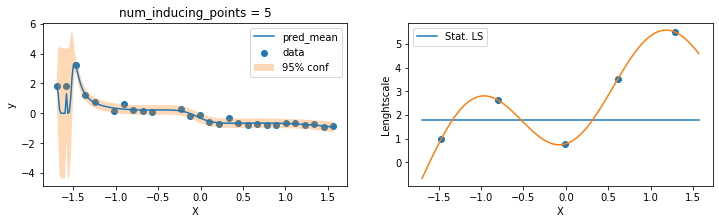

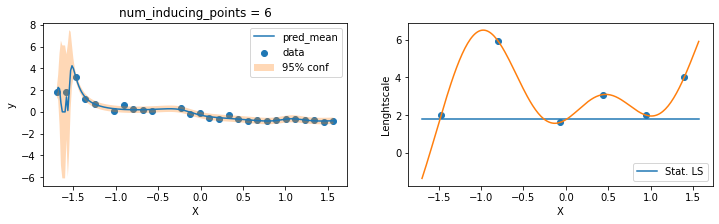

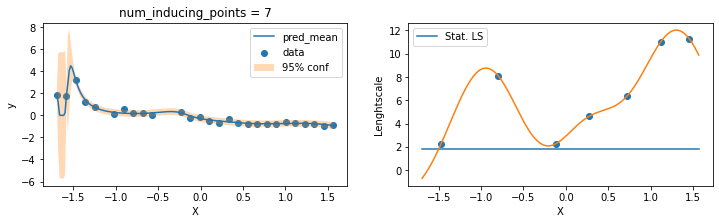

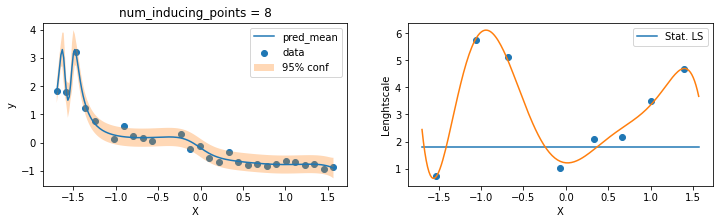

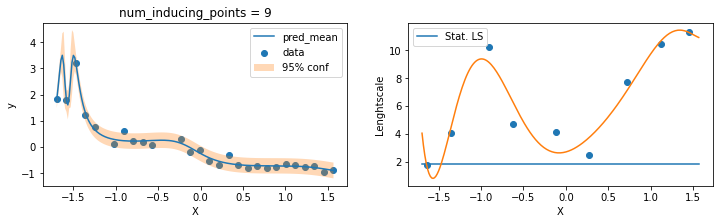

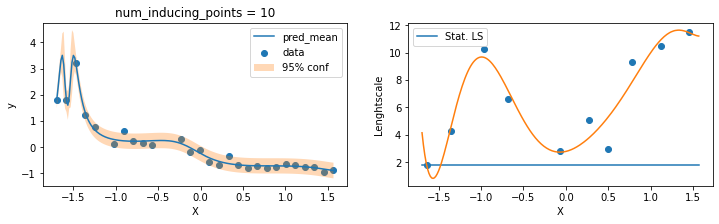

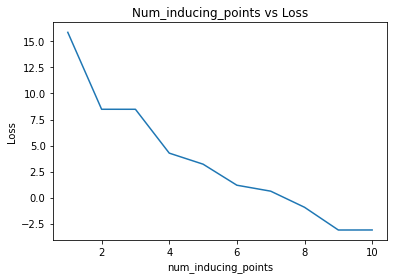

In [7]:
X_scaled = StandardScaler().fit_transform(X)
y_scaled = StandardScaler().fit_transform(y)

fit_predict_plot(X_scaled, y_scaled)

### Data 3 (della_gatta_gene data)

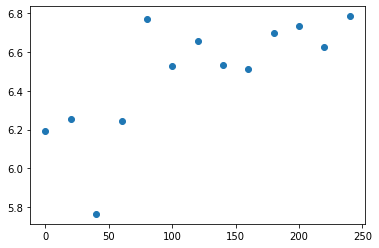

In [8]:
data = pods.datasets.della_gatta_TRP63_gene_expression(data_set='della_gatta',gene_number=937)

X = data['X']
y = data['Y']

plt.scatter(X, y);

n 10 seed 4
local_var:  0.9445
local_gp_ls0: 3.531
local_ls0:
    [0.54732206 3.50840916 0.81801602 9.47811853 0.67391974 0.79599084
     2.66082913 0.66956551 4.68788632 2.21974512]
global_var: 5.718
global_noise: 0.03154


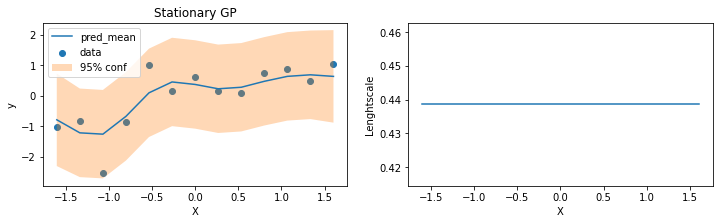

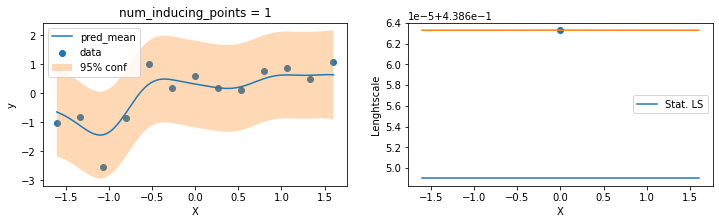

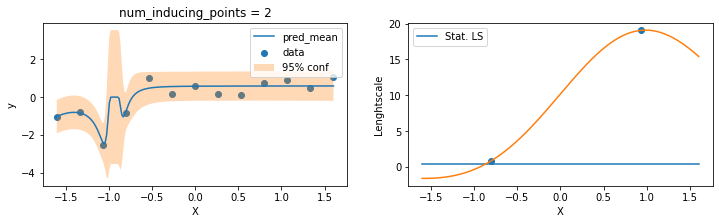

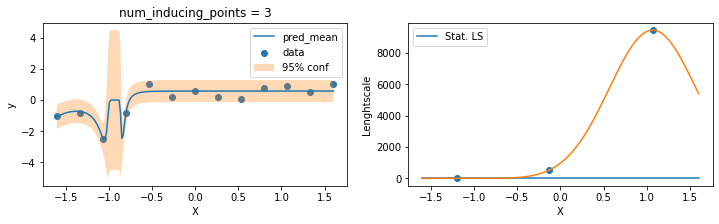

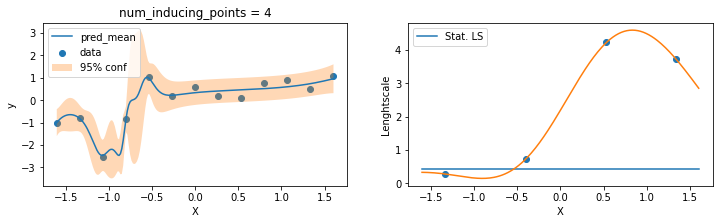

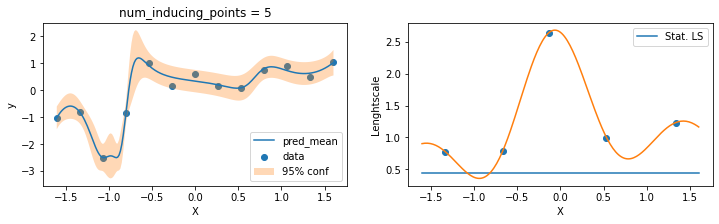

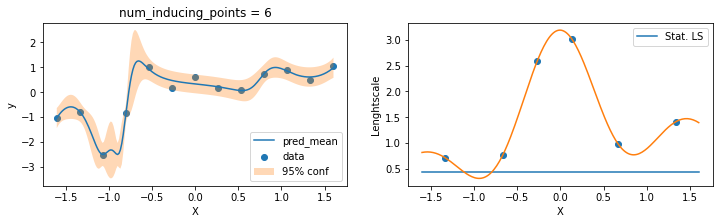

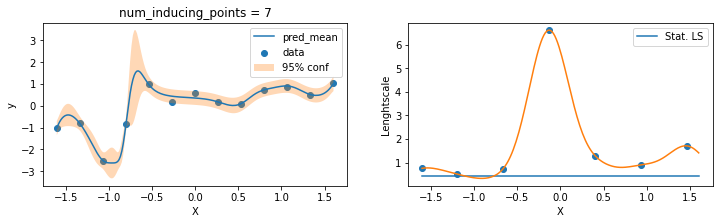

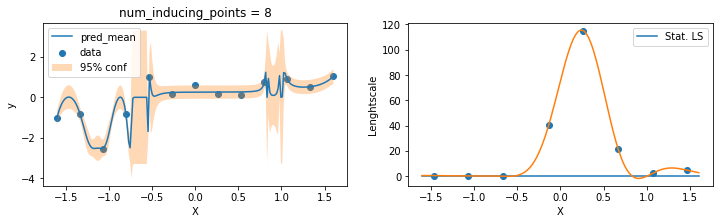

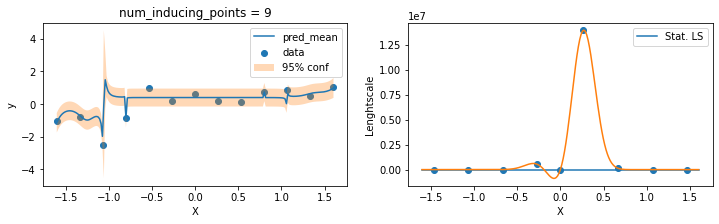

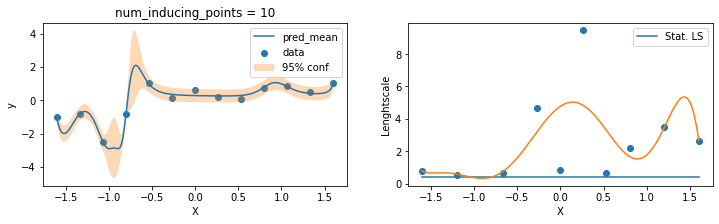

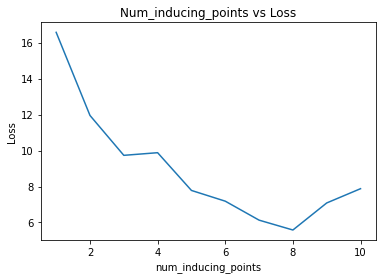

In [9]:
X_scaled = StandardScaler().fit_transform(X)
y_scaled = StandardScaler().fit_transform(y)

fit_predict_plot(X_scaled, y_scaled)

###  Data 4 (Step function overlap in between)

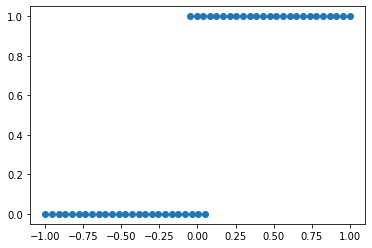

In [10]:
num_low=25
num_high=25
gap = -.1
noise=0.0001
X = np.vstack((np.linspace(-1, -gap/2.0, num_low)[:, np.newaxis],
              np.linspace(gap/2.0, 1, num_high)[:, np.newaxis]))
y = np.vstack((np.zeros((num_low, 1)), np.ones((num_high,1))))

plt.scatter(X, y);

n 10 seed 4
local_var:  1.0
local_gp_ls0: 0.4013
local_ls0:
    [2.79524771 0.97277784 1.49570344 2.23095347 0.49690243 1.59766091
     1.93290591 2.722066   0.66675612 0.45514189]
global_var: 1.333
global_noise: 0.157


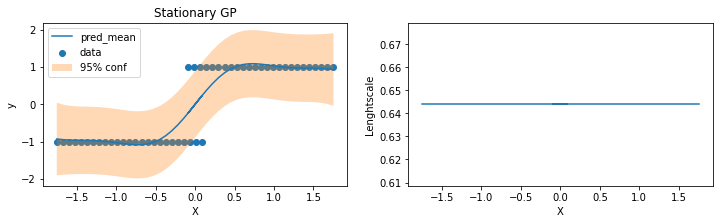

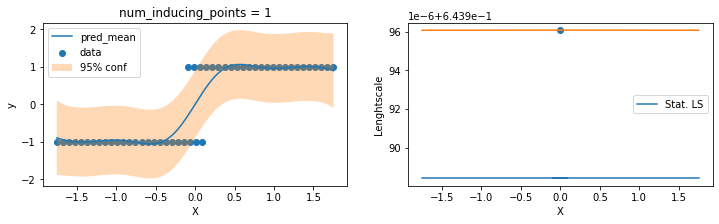

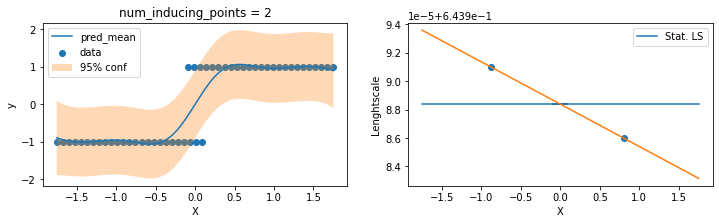

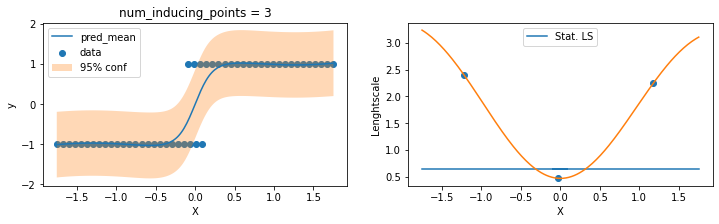

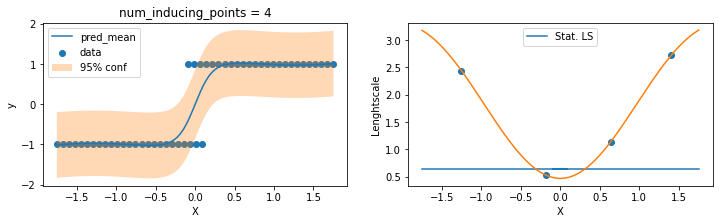

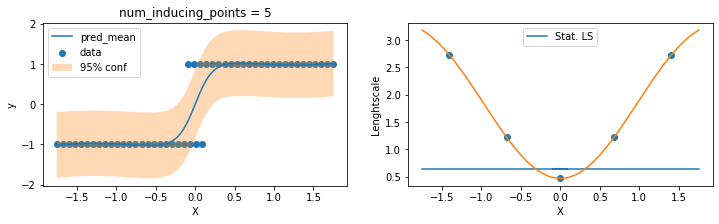

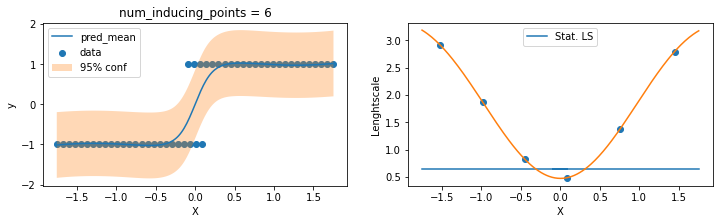

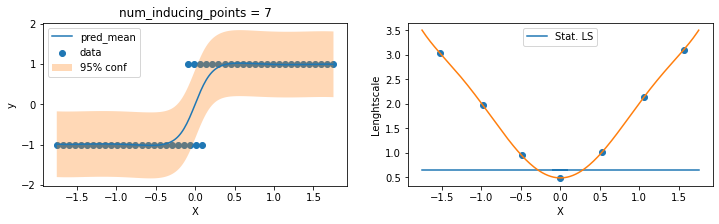

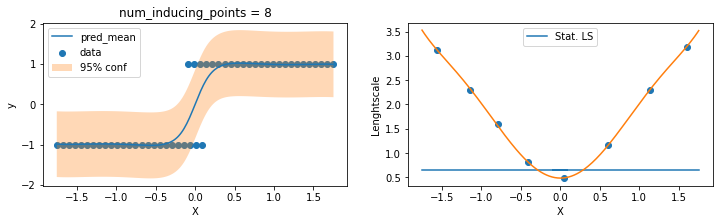

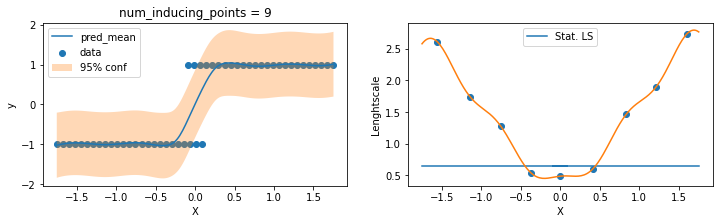

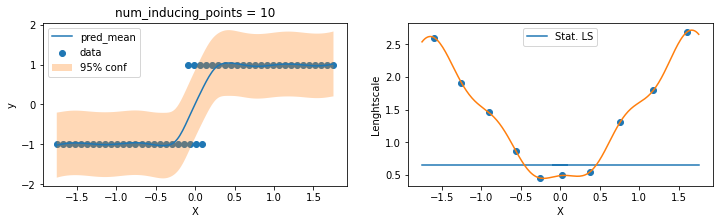

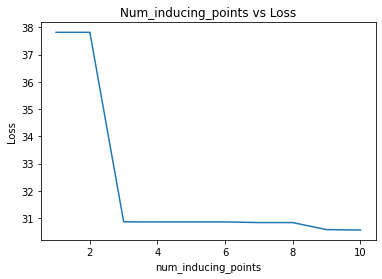

In [11]:
X_scaled = StandardScaler().fit_transform(X)
y_scaled = StandardScaler().fit_transform(y)

fit_predict_plot(X_scaled, y_scaled)

### Data 5 (Motorcycle helmet dataset)

Index(['ok', 'times', 'accel', 'strata', 'v'], dtype='object')


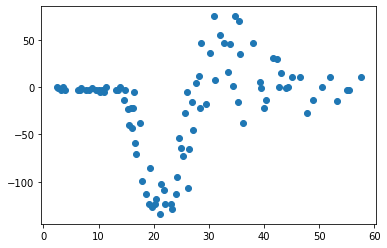

In [12]:
data = pd.read_csv('../../../motor.csv')
print(data.columns)
X = data['times'].values.reshape(-1,1)
y = data['accel'].values.reshape(-1,1)

plt.scatter(X, y);

n 10 seed 4
local_var:  3.252
local_gp_ls0: 2.055
local_ls0:
    [1.45759896 7.43092044 1.91736282 7.49548476 3.20223273 0.12606552
     1.16878574 0.10653288 1.83851634 2.53476357]
global_var: 2.875
global_noise: 0.3815


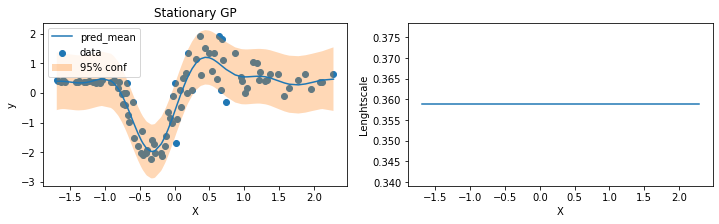

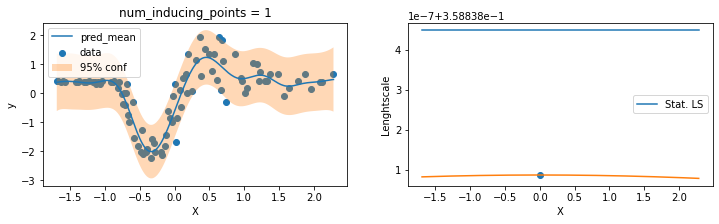

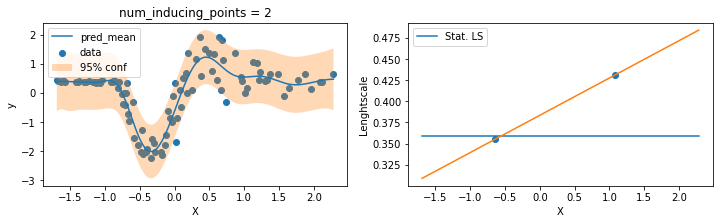

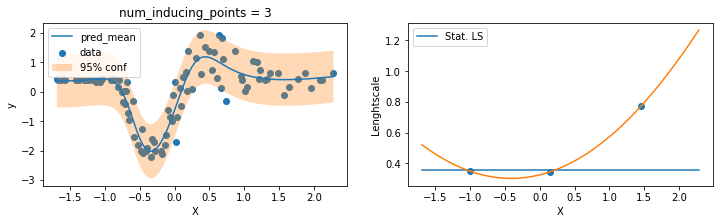

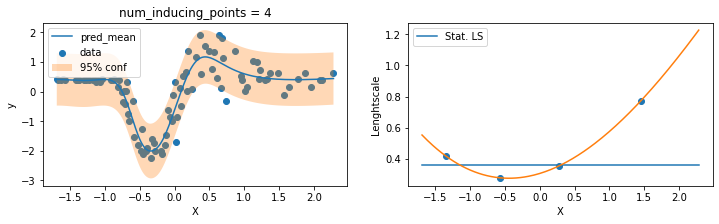

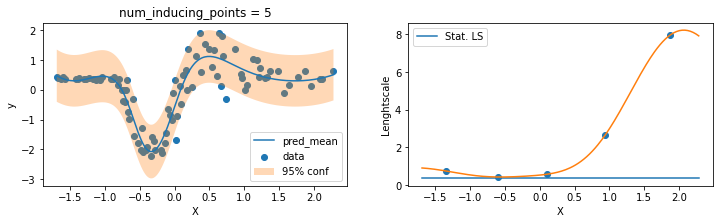

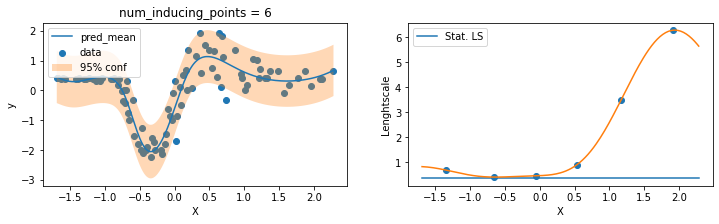

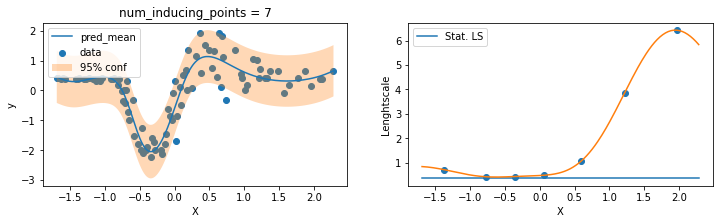

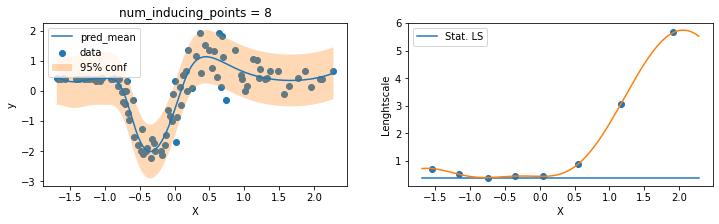

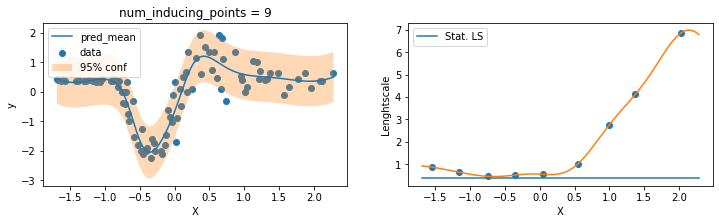

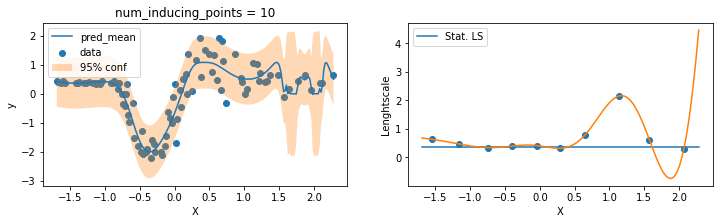

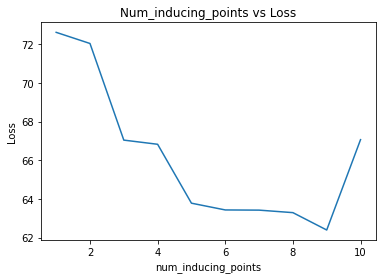

In [13]:
X_scaled = StandardScaler().fit_transform(X)
y_scaled = StandardScaler().fit_transform(y)

fit_predict_plot(X_scaled, y_scaled)

### Data 6 (Smooth-1D used by plagemann)

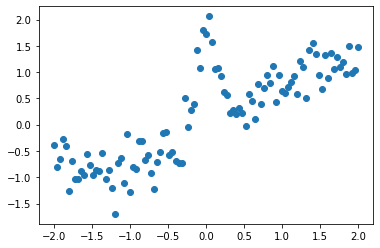

In [14]:
np.random.seed(0)
X = np.linspace(-2, 2, 101).reshape(-1,1)
y = np.sin(X) + 2 * np.exp(-30*X**2) + np.random.normal(0,0.3,101).reshape(-1,1)

plt.scatter(X, y);

n 10 seed 4
local_var:  0.9415
local_gp_ls0: 5.578
local_ls0:
    [4.40895306 0.58751026 0.72873016 3.08799834 0.8386647  0.92992788
     0.62949695 7.39119037 5.81930161 0.8473734 ]
global_var: 0.8937
global_noise: 0.1979


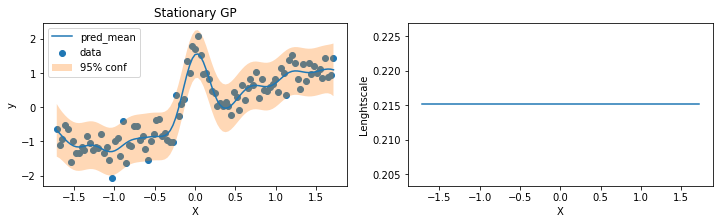

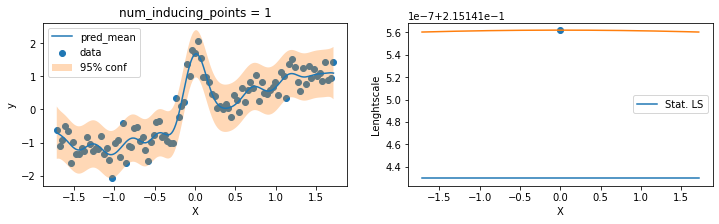

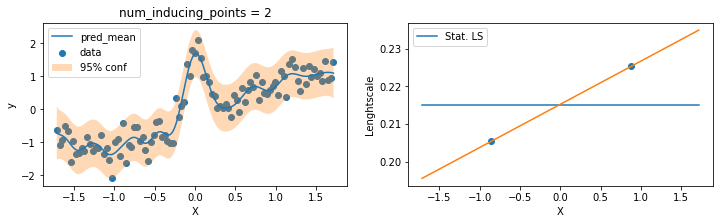

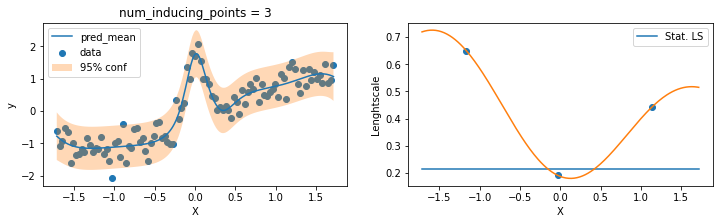

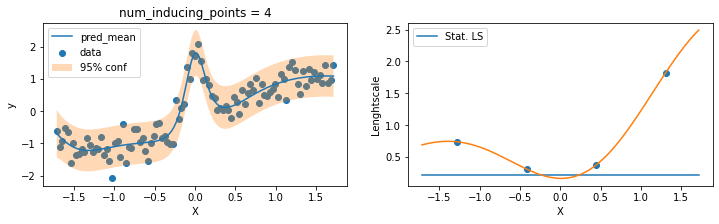

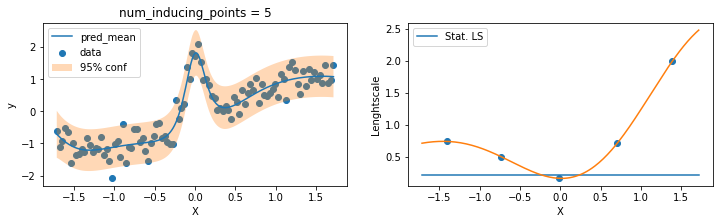

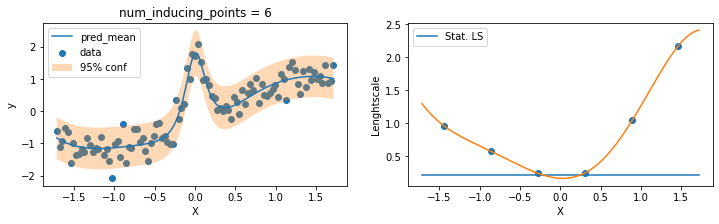

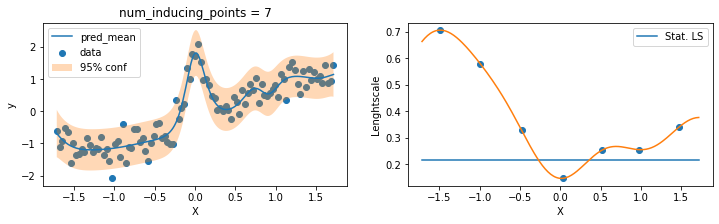

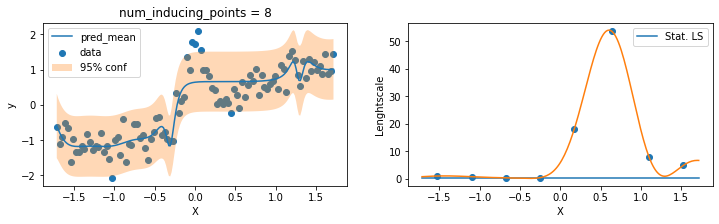

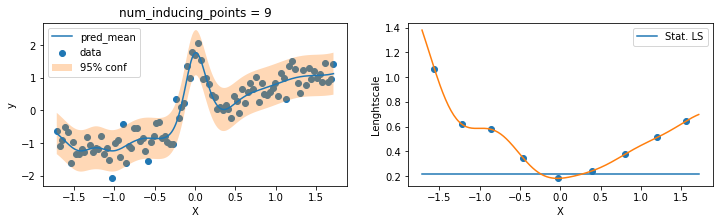

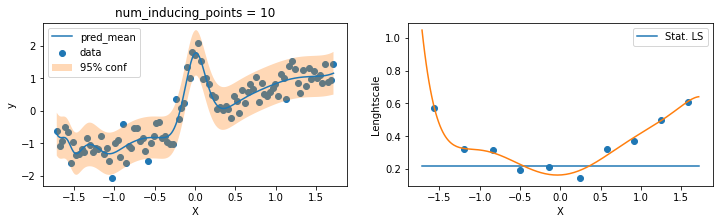

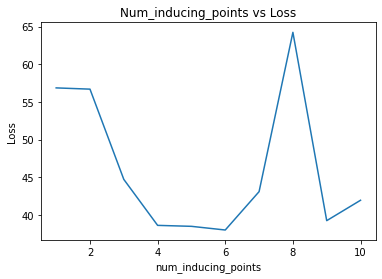

In [15]:
X_scaled = StandardScaler().fit_transform(X)
y_scaled = StandardScaler().fit_transform(y)

fit_predict_plot(X_scaled, y_scaled)

### Data 7 (Sin + Lin)

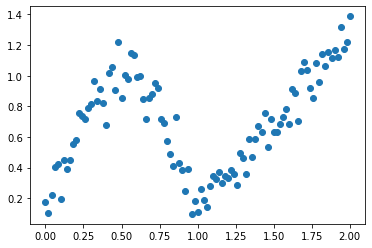

In [16]:
from patsy import dmatrix

np.random.seed(0)
X = np.linspace(0,2,101).reshape(-1,1)
y = np.concatenate([np.sin(3*X[:50]), X[50:]-0.8]) 
y = y + np.random.normal(0,0.1,101).reshape(-1,1)

plt.scatter(X, y);

n 10 seed 4
local_var:  1.131
local_gp_ls0: 1.858
local_ls0:
    [0.54651368 0.32776482 0.40872467 0.77277771 1.78895812 0.8672089
     0.81993043 1.32779298 0.78150105 2.2178813 ]
global_var: 1.897
global_noise: 0.1782


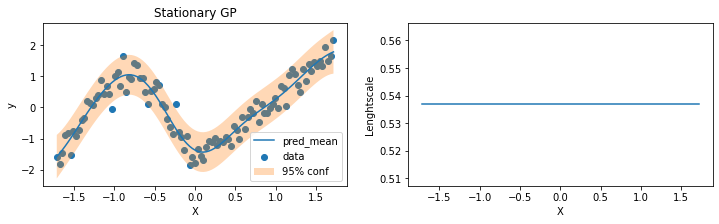

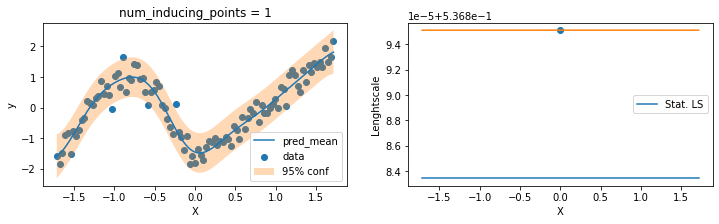

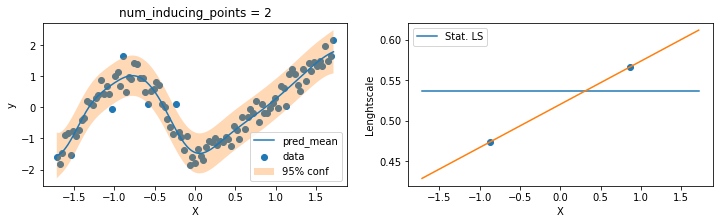

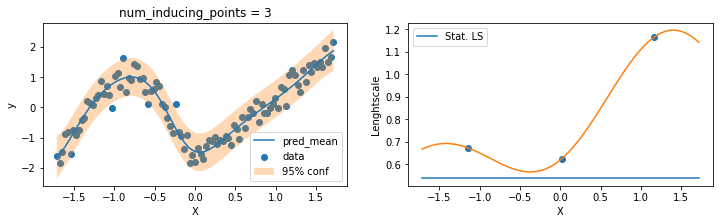

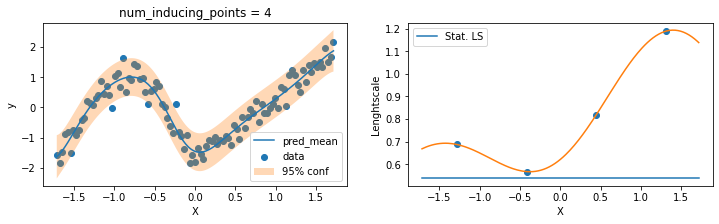

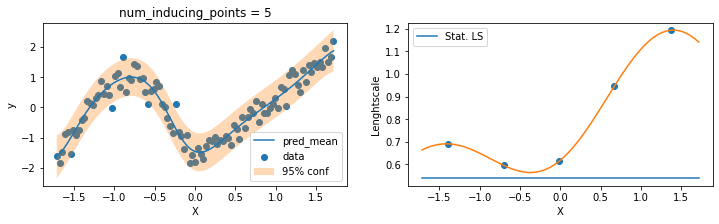

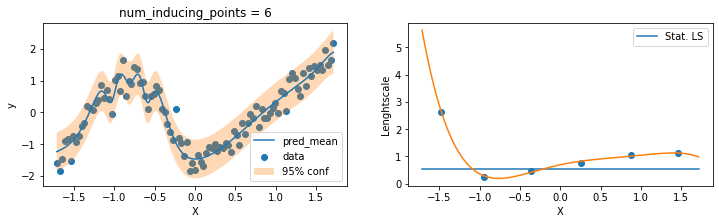

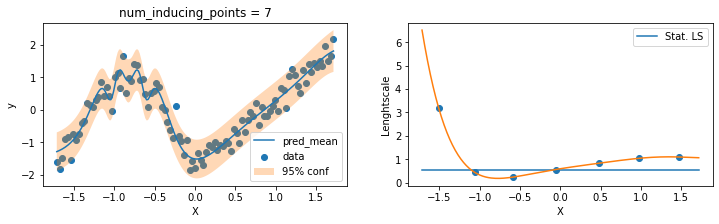

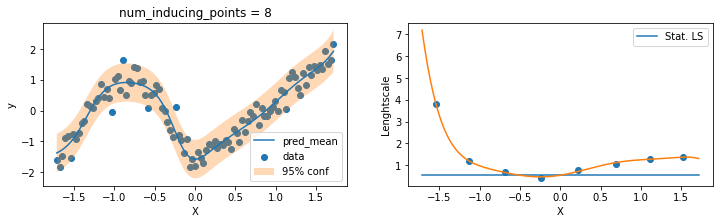

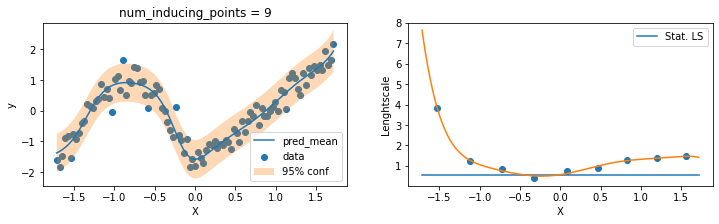

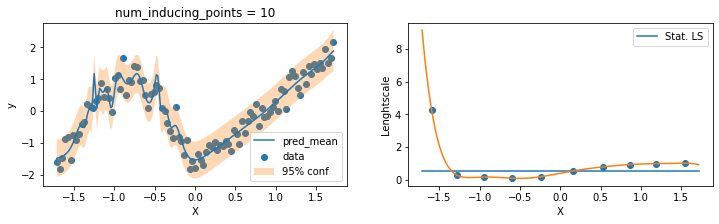

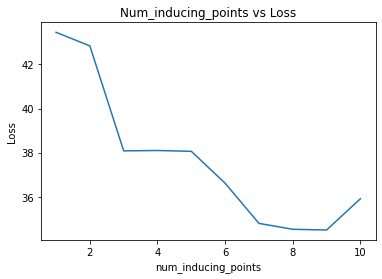

In [17]:
X_scaled = StandardScaler().fit_transform(X)
y_scaled = StandardScaler().fit_transform(y)

fit_predict_plot(X_scaled, y_scaled)

### 2D dataset

(121, 2) (121, 1)

Name : GP regression
Objective : -178.34765206551583
Number of Parameters : 4
Number of Optimization Parameters : 4
Updates : True
Parameters:
  GP_regression.           |                  value  |  constraints  |  priors
  rbf.variance             |    0.01124858304706409  |      +ve      |        
  rbf.lengthscale          |                   (2,)  |      +ve      |        
  Gaussian_noise.variance  |  0.0006690817891081977  |      +ve      |        


(GP_regression.rbf.lengthscale:
 Param([0.16535625, 0.23951605]),
 array([0.02586662]))

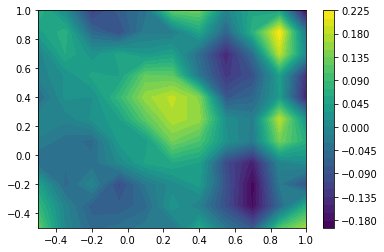

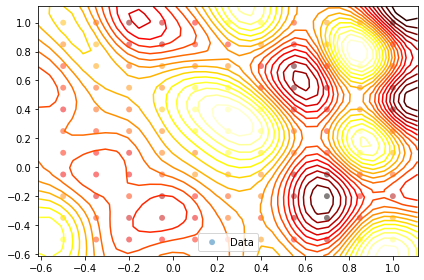

In [2]:
n = 11
np.random.seed(0)
x1 = np.sort(np.linspace(-0.5, 1, n))
# x2 = np.sort(np.random.uniform(-0.5, 1, n))
X1, X2 = np.meshgrid(x1, x1)

def simulate(a, b):
    bi = np.pi * (2*a + 0.5*b + 1)
    return 0.1 * (np.sin(a*bi) + np.sin(b*bi))

y = np.array([simulate(a,b) for a,b in zip(X1.ravel(), X2.ravel())]).reshape(-1,1) + np.random.normal(0,0.025, n*n).reshape(-1,1)
X = np.array([(a,b) for a,b in zip(X1.ravel(), X2.ravel())])

plt.contourf(X1, X2, y.reshape(n, n), levels=30);
plt.colorbar();

print(X.shape, y.shape)
m = GPy.models.GPRegression(X, y, GPy.kern.RBF(2, ARD=True))
m.optimize_restarts(10, verbose=False);
m.plot()
print(m)
m.kern.lengthscale, m['Gaussian_noise.variance']**.5

In [64]:
np.random.seed(0)
a = []
for i in range(121):
    a.append(np.random.normal(0,0.025,1))

np.std(a), np.random.normal(0, 0.025, 121).std()

(0.026026672128651705, 0.023439873654856717)

In [65]:
np.random.seed(0)
n = 31
x1_test = np.linspace(-0.5, 1, n)
X1_test, X2_test = np.meshgrid(x1_test, x1_test)

X_test = np.array([(a,b) for a,b in zip(X1_test.ravel(), X2_test.ravel())])
y_test = np.array([simulate(a,b) for a,b in zip(X1_test.ravel(), X2_test.ravel())]).reshape(-1,1)
print(X_test.shape, y_test.shape)

(961, 2) (961, 1)


0.05633485399180616

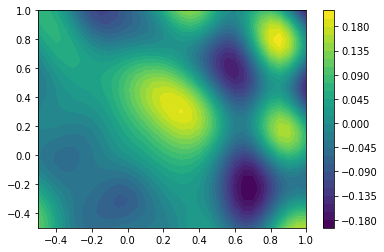

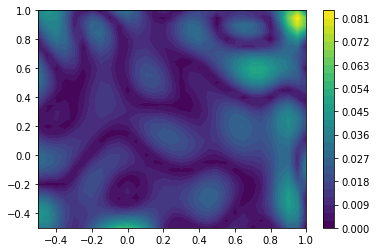

In [66]:
pred_y = m.predict(X_test)[0]

plt.contourf(X1_test, X2_test, pred_y.reshape(n,n), levels=30)
plt.colorbar()

plt.figure()
plt.contourf(X1_test, X2_test, np.abs(pred_y.reshape(n,n)-y_test.reshape(n,n)), levels=30)
plt.colorbar();
np.mean(np.square(y_test.ravel()-pred_y.ravel()))/np.var(y_test)

In [13]:
# for i in range(1, 5):
#     best_loss = np.inf
#     for j in range(10):
#         model = NSGPRegression(X, y, num_inducing_points=i, seed=j)
#         model.optimize()
# #         loss = model.GlobalGP(model.vs)
#         print('loss',loss,end=' ')
#         if loss<best_loss:
#             best_loss = loss
#     print('N_indu',i,'best_loss',best_loss)


for seed in range(10):
    model = NSGPRegression(X, y, num_inducing_points=12, seed=seed)
    model.optimize()
    pred_y = model.predict(X_test)[0].numpy()
#     plt.contourf(X1_test, X2_test, pred_y.reshape(n,n))
#     plt.scatter(model.X_bar[:,0], model.X_bar[:,1])
#     plt.colorbar()

    print(np.mean(np.square(y_test-pred_y))/np.var(y_test))
#     model.vs.print()

Caught exception during function evaluation:
    Traceback (most recent call last):
      File "/home/patel_zeel/anaconda3/lib/python3.8/site-packages/varz/tensorflow/minimise.py", line 39, in f_wrapped
        obj_value, grad = f_value_and_grad(x)
      File "/home/patel_zeel/anaconda3/lib/python3.8/site-packages/varz/tensorflow/minimise.py", line 27, in f_value_and_grad
        obj_value = f_vectorised(x)
      File "/home/patel_zeel/anaconda3/lib/python3.8/site-packages/varz/tensorflow/minimise.py", line 22, in f_vectorised
        return f(vs_copy)
      File "/home/patel_zeel/NSGPy/NSGPy/stheno/model.py", line 43, in GlobalGP
        l_list = self.LocalGP(vs, self.X)
      File "/home/patel_zeel/NSGPy/NSGPy/stheno/model.py", line 37, in LocalGP
        l = f_post(X[:, dim]).mean.mat
      File "/home/patel_zeel/anaconda3/lib/python3.8/site-packages/stheno/random.py", line 98, in mean
        self._resolve_mean(construct_zeros=True)
      File "/home/patel_zeel/anaconda3/lib/python

0.8520404235088197
Caught exception during function evaluation:
    Traceback (most recent call last):
      File "/home/patel_zeel/anaconda3/lib/python3.8/site-packages/varz/tensorflow/minimise.py", line 39, in f_wrapped
        obj_value, grad = f_value_and_grad(x)
      File "/home/patel_zeel/anaconda3/lib/python3.8/site-packages/varz/tensorflow/minimise.py", line 27, in f_value_and_grad
        obj_value = f_vectorised(x)
      File "/home/patel_zeel/anaconda3/lib/python3.8/site-packages/varz/tensorflow/minimise.py", line 22, in f_vectorised
        return f(vs_copy)
      File "/home/patel_zeel/NSGPy/NSGPy/stheno/model.py", line 43, in GlobalGP
        l_list = self.LocalGP(vs, self.X)
      File "/home/patel_zeel/NSGPy/NSGPy/stheno/model.py", line 37, in LocalGP
        l = f_post(X[:, dim]).mean.mat
      File "/home/patel_zeel/anaconda3/lib/python3.8/site-packages/stheno/random.py", line 98, in mean
        self._resolve_mean(construct_zeros=True)
      File "/home/patel_zeel/a

0.7440135462836466
Caught exception during function evaluation:
    Traceback (most recent call last):
      File "/home/patel_zeel/anaconda3/lib/python3.8/site-packages/varz/tensorflow/minimise.py", line 39, in f_wrapped
        obj_value, grad = f_value_and_grad(x)
      File "/home/patel_zeel/anaconda3/lib/python3.8/site-packages/varz/tensorflow/minimise.py", line 27, in f_value_and_grad
        obj_value = f_vectorised(x)
      File "/home/patel_zeel/anaconda3/lib/python3.8/site-packages/varz/tensorflow/minimise.py", line 22, in f_vectorised
        return f(vs_copy)
      File "/home/patel_zeel/NSGPy/NSGPy/stheno/model.py", line 43, in GlobalGP
        l_list = self.LocalGP(vs, self.X)
      File "/home/patel_zeel/NSGPy/NSGPy/stheno/model.py", line 37, in LocalGP
        l = f_post(X[:, dim]).mean.mat
      File "/home/patel_zeel/anaconda3/lib/python3.8/site-packages/stheno/random.py", line 98, in mean
        self._resolve_mean(construct_zeros=True)
      File "/home/patel_zeel/a

0.823018186368402


In [15]:
from scipy.io import savemat

In [24]:
savemat('./data.mat', {'X':X, 'y':y, 'X_test': X_test, 'y_test':y_test, 
                       'X1':X1, 'X2':X2, 'X1_test':X1_test, 'X2_test':X2_test})

In [23]:
X.shape, y.shape, X_test.shape, y_test.shape

((121, 2), (121, 1), (961, 2), (961, 1))